# 05Tools: Model Explainability

Model explainability help understand model outputs = predictions.  There are two approaches here:
- Feature-Based Explanations
    - How much did each feature contribute to a specific prediction
    - Uses a baseline for comparison, usually based on the central value for each feature from the training data
    - Helpful for recognizing bias and finding areas for improvement
    - Read more about [feature attributions and methods](https://cloud.google.com/vertex-ai/docs/explainable-ai/overview#feature_attributions)
    - Examples in [github.com/GoogleClouPlatform/vertex-ai-samples](https://github.com/GoogleCloudPlatform/vertex-ai-samples/tree/main/notebooks/official/explainable_ai)
- Example-Based Explanations
    - Return similar examples, neighbors, to help understand predictions
    - Along with prediction, get example from the source data that are most similar to the prediction to further understand "why?"
    
Vertex AI can serve explanations during online and batch predictions.  

### Prerequisites:
-  At least 1 of the notebooks in this series [05, 05a-05i]

### Conceptual Flow & Workflow
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/05tools_explain_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/05tools_explain_console.png" width="45%">
</p>

---
## Setup

inputs:

In [2]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [3]:
REGION = 'us-central1'
EXPERIMENT = '05_explanability'
SERIES = '05'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'
DEPLOY_IMAGE='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-7:latest'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [4]:
from google.cloud import aiplatform
from google.cloud import bigquery

import tensorflow as tf

from datetime import datetime
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

clients:

In [5]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client()

parameters:

In [6]:
BUCKET = PROJECT_ID
DIR = f"temp/{EXPERIMENT}"

In [7]:
# Give service account roles/storage.objectAdmin permissions
# Console > IAM > Select Account <projectnumber>-compute@developer.gserviceaccount.com > edit - give role
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

environment:

In [8]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Get Vertex AI Endpoint And Deployed Model

In [9]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
endpoint = endpoints[0]

In [10]:
endpoint.display_name

'05_fraud'

In [11]:
model = aiplatform.Model(
    model_name = endpoint.list_models()[0].model+f'@{endpoint.list_models()[0].model_version_id}'
)

In [12]:
model.display_name

'05i_fraud'

In [13]:
model.versioned_resource_name

'projects/1026793852137/locations/us-central1/models/model_05i_fraud@1'

In [14]:
model.uri

'gs://statmike-mlops-349915/fraud/models/05/05i/20220826194138/7/model'

---
## Retrieve Records For Prediction & Explanation

In [15]:
n = 1000
pred = bq.query(query = f"SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE} WHERE splits='TEST' LIMIT {n}").to_dataframe()

In [16]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,35337,1.092844,-0.013230,1.359829,2.731537,-0.707357,0.873837,-0.796130,0.437707,0.396770,...,-0.167647,0.027557,0.592115,0.219695,0.036970,0.010984,0.0,0,a1b10547-d270-48c0-b902-7a0f735dadc7,TEST
1,60481,1.238973,0.035226,0.063003,0.641406,-0.260893,-0.580097,0.049938,-0.034733,0.405932,...,-0.057718,0.104983,0.537987,0.589563,-0.046207,-0.006212,0.0,0,814c62c8-ade4-47d5-bf83-313b0aafdee5,TEST
2,139587,1.870539,0.211079,0.224457,3.889486,-0.380177,0.249799,-0.577133,0.179189,-0.120462,...,0.180776,-0.060226,-0.228979,0.080827,0.009868,-0.036997,0.0,0,d08a1bfa-85c5-4f1b-9537-1c5a93e6afd0,TEST
3,162908,-3.368339,-1.980442,0.153645,-0.159795,3.847169,-3.516873,-1.209398,-0.292122,0.760543,...,-1.171627,0.214333,-0.159652,-0.060883,1.294977,0.120503,0.0,0,802f3307-8e5a-4475-b795-5d5d8d7d0120,TEST


Remove columns not included as features in the model:

In [17]:
newobs = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')
#newobs[0]

In [18]:
len(newobs)

1000

---
## Feature-Based Explanations

In Vertex AI you [configure explanations](https://cloud.google.com/vertex-ai/docs/explainable-ai/configuring-explanations-feature-based) by providing an `explanationSpec`. For feature-based explanations this can be done when registering the model in the Model Registry.  You can also set, or override, the `explanationSpec` when deploying models to and endpoints or configuring batch predictions jobs.


### ExplanationSpec

From the [Python client for Vertex AI](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform), the `explanationSpec` is provided by two input parameters: `explanation_parameters` and `explanation_metadata`.  The parameters must be passed together and can be set (or overwritten):
- When registering the model in the Vertex AI Model Registry:
    - https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_upload
- When deploying a model the a Vertex AI Endpoint for online serving:
    - https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint#google_cloud_aiplatform_Endpoint_deploy
- When creating a Vertex AI Batch Prediciton Job:
    - https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.BatchPredictionJob#google_cloud_aiplatform_BatchPredictionJob_create


#### Explanation Parameters

The [Explanation Parameters](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.types.ExplanationParameters) included setting the method of attribution along with associated parameters for the method.  A review of methods can be found [here](https://cloud.google.com/vertex-ai/docs/explainable-ai/overview#compare-methods).

In [19]:
explanation_parameters = aiplatform.explain.ExplanationParameters({'integrated_gradients_attribution': {'step_count': 50}})
explanation_parameters

integrated_gradients_attribution {
  step_count: 50
}

#### Explanation Metadata

The [Explanation Metadata](https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/ExplanationSpec#explanationmetadata) specifys the inputs metadata and outputs metadata.  For a TensorFlow model there is a tool for building the explanation metadata as used below:
- This is documented here: https://googleapis.dev/python/aiplatform/latest/index.html#explainable-ai-get-metadata


In [21]:
from google.cloud.aiplatform.explain.metadata.tf.v2 import saved_model_metadata_builder
builder = saved_model_metadata_builder.SavedModelMetadataBuilder(model.uri)
explanation_metadata = builder.get_metadata_protobuf()

In [27]:
explanation_metadata

inputs {
  key: "Amount"
  value {
    input_tensor_name: "Amount"
  }
}
inputs {
  key: "Time"
  value {
    input_tensor_name: "Time"
  }
}
inputs {
  key: "V1"
  value {
    input_tensor_name: "V1"
  }
}
inputs {
  key: "V10"
  value {
    input_tensor_name: "V10"
  }
}
inputs {
  key: "V11"
  value {
    input_tensor_name: "V11"
  }
}
inputs {
  key: "V12"
  value {
    input_tensor_name: "V12"
  }
}
inputs {
  key: "V13"
  value {
    input_tensor_name: "V13"
  }
}
inputs {
  key: "V14"
  value {
    input_tensor_name: "V14"
  }
}
inputs {
  key: "V15"
  value {
    input_tensor_name: "V15"
  }
}
inputs {
  key: "V16"
  value {
    input_tensor_name: "V16"
  }
}
inputs {
  key: "V17"
  value {
    input_tensor_name: "V17"
  }
}
inputs {
  key: "V18"
  value {
    input_tensor_name: "V18"
  }
}
inputs {
  key: "V19"
  value {
    input_tensor_name: "V19"
  }
}
inputs {
  key: "V2"
  value {
    input_tensor_name: "V2"
  }
}
inputs {
  key: "V20"
  value {
    input_tensor_name: "V2

### Create An Endpoint

In [28]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    endpoint = aiplatform.Endpoint.create(
        display_name = f"{SERIES}_{BQ_DATASET}",
        labels = {'series' : f"{SERIES}"}    
    )
    print(f"Endpoint Created: {endpoint.resource_name}")

Endpoint Exists: projects/1026793852137/locations/us-central1/endpoints/4573537362990071808


In [29]:
endpoint.display_name

'05_fraud'

### Deploy Model To Endpoint
At the top of this notebook a current endpoint was used to retrieve the model that was used to create the explanations metadata.  In the cell below the same model is deployed again with 100% of traffic, this time with explanations metadata.  This demonstrates that the `explanationSpec` can be provided with the model upload to the Model Registry or at the point of model use for Endponts or Batch Prediction Jobs. 

In [30]:
endpoint.deploy(
    model = model,
    deployed_model_display_name = model.display_name,
    traffic_percentage = 100,
    machine_type = DEPLOY_COMPUTE,
    min_replica_count = 1,
    max_replica_count = 1,
    explanation_parameters = explanation_parameters,
    explanation_metadata = explanation_metadata
) 

Deploying Model projects/1026793852137/locations/us-central1/models/model_05i_fraud to Endpoint : projects/1026793852137/locations/us-central1/endpoints/4573537362990071808
Deploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/4573537362990071808/operations/7112138531308306432


/opt/conda/lib/python3.7/site-packages/proto/marshal/rules/enums.py:40: UserWarning: Unrecognized DeploymentResourcesType enum value: 3
  value=value,


Endpoint model deployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/4573537362990071808


### Remove Deployed Models without Traffic

In [31]:
for deployed_model in endpoint.list_models():
    if deployed_model.id in endpoint.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint.traffic_split[deployed_model.id]}")
    else:
        endpoint.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

Undeploying Endpoint model: projects/1026793852137/locations/us-central1/endpoints/4573537362990071808
Undeploy Endpoint model backing LRO: projects/1026793852137/locations/us-central1/endpoints/4573537362990071808/operations/876904847213854720
Endpoint model undeployed. Resource name: projects/1026793852137/locations/us-central1/endpoints/4573537362990071808
Undeploying 05i_fraud with version 1 because it has no traffic.
Model 05i_fraud with version 1 has traffic = 100


In [32]:
endpoint.traffic_split

{'5475220460650102784': 100}

In [35]:
endpoint.list_models()[0]

id: "5475220460650102784"
model: "projects/1026793852137/locations/us-central1/models/model_05i_fraud"
display_name: "05i_fraud"
create_time {
  seconds: 1661565734
  nanos: 379696000
}
dedicated_resources {
  machine_spec {
    machine_type: "n1-standard-4"
  }
  min_replica_count: 1
  max_replica_count: 1
}
explanation_spec {
  parameters {
    integrated_gradients_attribution {
      step_count: 50
    }
  }
  metadata {
    inputs {
      key: "Amount"
      value {
        input_tensor_name: "Amount"
      }
    }
    inputs {
      key: "Time"
      value {
        input_tensor_name: "Time"
      }
    }
    inputs {
      key: "V1"
      value {
        input_tensor_name: "V1"
      }
    }
    inputs {
      key: "V10"
      value {
        input_tensor_name: "V10"
      }
    }
    inputs {
      key: "V11"
      value {
        input_tensor_name: "V11"
      }
    }
    inputs {
      key: "V12"
      value {
        input_tensor_name: "V12"
      }
    }
    inputs {
      k

### Get Prediction: Python Client

In [36]:
instances = [json_format.ParseDict(newobs[0], Value())]

In [37]:
prediction = endpoint.predict(instances = instances)
prediction

Prediction(predictions=[[0.998993218, 0.00100678555]], deployed_model_id='5475220460650102784', model_version_id='1', model_resource_name='projects/1026793852137/locations/us-central1/models/model_05i_fraud', explanations=None)

In [38]:
prediction.predictions[0]

[0.998993218, 0.00100678555]

In [39]:
np.argmax(prediction.predictions[0])

0

### Get Prediction & Explanation: Python Client

In [70]:
explanation = endpoint.explain(instances = instances)

In [71]:
explanation.predictions

[[0.998993218, 0.00100678555]]

In [72]:
explanation.explanations

[attributions {
  baseline_output_value: 0.9999043941497803
  instance_output_value: 0.9989932179450989
  feature_attributions {
    struct_value {
      fields {
        key: "Amount"
        value {
          number_value: 0.0
        }
      }
      fields {
        key: "Time"
        value {
          number_value: -0.000349865218289453
        }
      }
      fields {
        key: "V1"
        value {
          number_value: 0.0004099055037639018
        }
      }
      fields {
        key: "V10"
        value {
          number_value: 0.0002407934147236343
        }
      }
      fields {
        key: "V11"
        value {
          number_value: 0.0001822769519944738
        }
      }
      fields {
        key: "V12"
        value {
          number_value: 0.000543946283436166
        }
      }
      fields {
        key: "V13"
        value {
          number_value: -0.0002429582977135693
        }
      }
      fields {
        key: "V14"
        value {
          number_va

In [42]:
print("attribution:")
print("baseline output:",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output:",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index:",explanation.explanations[0].attributions[0].output_index)
print("output_name:",explanation.explanations[0].attributions[0].output_name)
print("approximation error:",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output: 0.9999043941497803
instance output: 0.9989932179450989
output_index: [0]
output_name: prediction_layer
approximation error: 0.04364097890271738


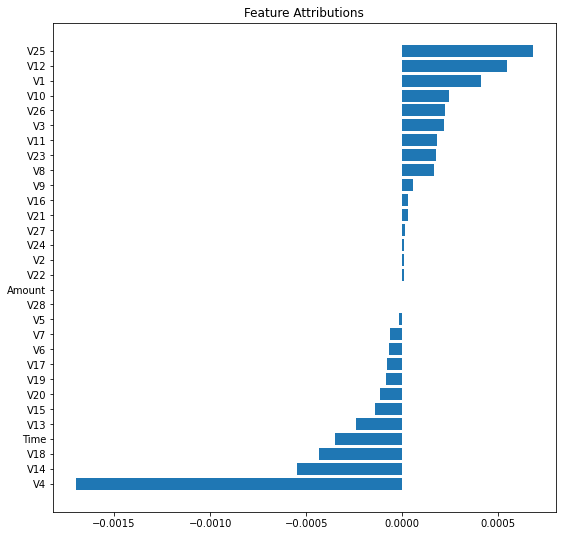

In [43]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
plt.title('Feature Attributions')
fig.show()

In the plot above, each bar represents the attribution for a feature, or how much the feature affected the change in the predicted value relative to the baseline value.

In [44]:
sum_attributions = 0
for k in explanation.explanations[0].attributions[0].feature_attributions:
    sum_attributions += explanation.explanations[0].attributions[0].feature_attributions[k]

print("baseline output:",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output:",explanation.explanations[0].attributions[0].instance_output_value)
print("Total Attribution:", sum_attributions)
print("instance - baseline:",explanation.explanations[0].attributions[0].instance_output_value-explanation.explanations[0].attributions[0].baseline_output_value)

baseline output: 0.9999043941497803
instance output: 0.9989932179450989
Total Attribution: -0.0008714111467464482
instance - baseline: -0.0009111762046813965


### Explainable AI SDK: Local Explanations
When using Vertex AI Workbench based user-manged notebooks you have access to the [Explainable AI SDK](https://github.com/GoogleCloudPlatform/explainable_ai_sdk).  This section demonstrates local explanations using the SDK.

This can be helpful for iterating on setting up explanations before deploying the model with `explanationSpec`:
- try different baselines
- setup vizualization settings for image models
- adjust parameters like steps (integrated gradients) or paths (sampled Shapley)

In [45]:
import explainable_ai_sdk
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder

In [46]:
builder = SavedModelMetadataBuilder(model.uri)
builder.save_model_with_metadata(f'{DIR}/model')
!ls -l -R {DIR}/model

INFO:tensorflow:Assets written to: temp/05_explanability/model/assets


INFO:tensorflow:Assets written to: temp/05_explanability/model/assets


temp/05_explanability/model:
total 508
drwxr-xr-x 2 jupyter jupyter   4096 Aug 27 02:11 assets
-rw-r--r-- 1 jupyter jupyter   3541 Aug 27 02:11 explanation_metadata.json
-rw-r--r-- 1 jupyter jupyter 505380 Aug 27 02:11 saved_model.pb
drwxr-xr-x 2 jupyter jupyter   4096 Aug 27 02:11 variables

temp/05_explanability/model/assets:
total 0

temp/05_explanability/model/variables:
total 52
-rw-r--r-- 1 jupyter jupyter 45865 Aug 27 02:11 variables.data-00000-of-00001
-rw-r--r-- 1 jupyter jupyter  2122 Aug 27 02:11 variables.index


In [47]:
local_model = explainable_ai_sdk.load_model_from_local_path(
    model_path = f'{DIR}/model',
    config = explainable_ai_sdk.IntegratedGradientsConfig(step_count = 50)
)

In [48]:
type(local_model)

explainable_ai_sdk.model.local_model.LocalModel

In [49]:
newobs[0]

{'Time': 35337,
 'V1': 1.0928441854981998,
 'V2': -0.0132303486713432,
 'V3': 1.35982868199426,
 'V4': 2.7315370965921004,
 'V5': -0.707357349219652,
 'V6': 0.8738370029866129,
 'V7': -0.7961301510622031,
 'V8': 0.437706509544851,
 'V9': 0.39676985012996396,
 'V10': 0.587438102569443,
 'V11': -0.14979756231827498,
 'V12': 0.29514781622888103,
 'V13': -1.30382621882143,
 'V14': -0.31782283120234495,
 'V15': -2.03673231037199,
 'V16': 0.376090905274179,
 'V17': -0.30040350116459497,
 'V18': 0.433799615590844,
 'V19': -0.145082264348681,
 'V20': -0.240427548108996,
 'V21': 0.0376030733329398,
 'V22': 0.38002620963091405,
 'V23': -0.16764742731151097,
 'V24': 0.0275573495476881,
 'V25': 0.59211469704354,
 'V26': 0.219695164116351,
 'V27': 0.0369695108704894,
 'V28': 0.010984441006191,
 'Amount': 0.0}

Update the dictionary to have values as tensors:

In [52]:
{key: tf.constant([value], dtype=tf.float64, name = key) for key, value in newobs[0].items()}

{'Time': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([35337.])>,
 'V1': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.09284419])>,
 'V2': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.01323035])>,
 'V3': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.35982868])>,
 'V4': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([2.7315371])>,
 'V5': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.70735735])>,
 'V6': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.873837])>,
 'V7': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.79613015])>,
 'V8': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.43770651])>,
 'V9': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.39676985])>,
 'V10': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.5874381])>,
 'V11': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.14979756])>,
 'V12': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.29514782])>,
 'V13': <tf.Tensor: shape=(1,), dtype

In [53]:
prediction = local_model.predict(instances = [{key: tf.constant([value], dtype=tf.float64, name = key) for key, value in newobs[0].items()}])
prediction

[{'prediction_layer': [0.9989932179450989, 0.0010067860130220652]}]

In [54]:
explanation = local_model.explain(instances = [{key: tf.constant([value], dtype=tf.float64, name = key) for key, value in newobs[0].items()}])
explanation

In [55]:
explanation[0].feature_importance()

{'V13': -0.00025991094298660755,
 'V24': 1.0715451935539022e-05,
 'V28': -5.008934067518567e-07,
 'V21': 2.809919351420831e-05,
 'V18': -0.0004297656414564699,
 'V4': -0.0017229134682565928,
 'V1': 0.000397511146729812,
 'V11': 0.0001818822493078187,
 'V17': -8.126850298140198e-05,
 'V25': 0.0006792759522795677,
 'V15': -0.00013671354099642485,
 'V26': 0.00021825265139341354,
 'V7': -6.966513319639489e-05,
 'Amount': 0.0,
 'V5': -1.5059349607327022e-05,
 'Time': -0.0003467779897619039,
 'V16': 2.7743155442294665e-05,
 'V20': -0.0001171016920125112,
 'V12': 0.0005402057431638241,
 'V3': 0.00022823952895123512,
 'V9': 5.4535779781872407e-05,
 'V2': 9.190739547193516e-06,
 'V6': -7.157724030548707e-05,
 'V22': 8.495044312439859e-06,
 'V23': 0.00017433347238693386,
 'V19': -8.475522190565243e-05,
 'V10': 0.0002397342468611896,
 'V27': 1.3548216884373687e-05,
 'V14': -0.000550235970877111,
 'V8': 0.0001588204177096486}

In [56]:
explanation[0].as_tensors()

{'V13': array([-0.00025991], dtype=float32),
 'V24': array([1.0715452e-05], dtype=float32),
 'V28': array([-5.008934e-07], dtype=float32),
 'V21': array([2.8099194e-05], dtype=float32),
 'V18': array([-0.00042977], dtype=float32),
 'V4': array([-0.00172291], dtype=float32),
 'V1': array([0.00039751], dtype=float32),
 'V11': array([0.00018188], dtype=float32),
 'V17': array([-8.12685e-05], dtype=float32),
 'V25': array([0.00067928], dtype=float32),
 'V15': array([-0.00013671], dtype=float32),
 'V26': array([0.00021825], dtype=float32),
 'V7': array([-6.966513e-05], dtype=float32),
 'Amount': array([-0.], dtype=float32),
 'V5': array([-1.505935e-05], dtype=float32),
 'Time': array([-0.00034678], dtype=float32),
 'V16': array([2.7743155e-05], dtype=float32),
 'V20': array([-0.0001171], dtype=float32),
 'V12': array([0.00054021], dtype=float32),
 'V3': array([0.00022824], dtype=float32),
 'V9': array([5.453578e-05], dtype=float32),
 'V2': array([9.19074e-06], dtype=float32),
 'V6': array([

Label Index 0
Example Score: 0.9990
Baseline Score: 0.9999
Approximation Error: 0.0049


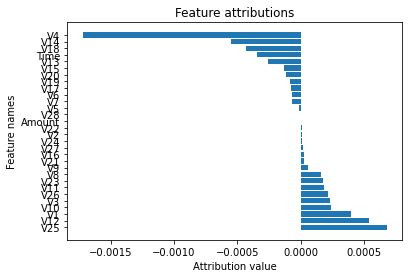

In [57]:
explanation[0].visualize_attributions()

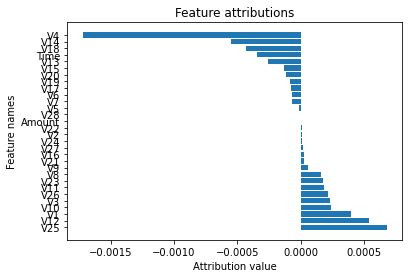

In [58]:
explanation[0].visualize_top_k_features(k=len(newobs[0]))

### Explainable AI SDK With Vertex AI Endpoints
The features of the Explainable AI SDK are also useful for Vertex AI Endpoints.  The example below shows using the SDK with a Vertex AI Endpoint, the one setup in this notebook with `explanationSpec`.

In [59]:
vertex_explain = explainable_ai_sdk.load_model_from_vertex(
    project = PROJECT_ID,
    region = REGION,
    endpoint_id = endpoint.resource_name.split('/')[-1]
)

In [60]:
prediction = vertex_explain.predict(instances = [newobs[0]])
prediction

{'predictions': [[0.998993218, 0.00100678555]],
 'deployedModelId': '5475220460650102784',
 'model': 'projects/1026793852137/locations/us-central1/models/model_05i_fraud',
 'modelDisplayName': '05i_fraud',
 'modelVersionId': '1'}

In [61]:
explanation = vertex_explain.explain(instances = [newobs[0]])

In [62]:
explanation[0].feature_importance()

{'V10': 0.0002407934147236343,
 'V9': 5.469417324454105e-05,
 'V11': 0.0001822769519944738,
 'V4': -0.001697567480199924,
 'V7': -6.686503932207739e-05,
 'V23': 0.0001753213361564571,
 'V27': 1.326837387492595e-05,
 'V2': 9.2732114362436e-06,
 'V20': -0.0001171964663619994,
 'V1': 0.0004099055037639018,
 'V12': 0.000543946283436166,
 'V17': -7.964999527127166e-05,
 'V6': -7.082372395243857e-05,
 'V28': -7.47253957903993e-07,
 'V21': 2.793505293773866e-05,
 'V5': -1.609594325290559e-05,
 'V3': 0.000216359876022467,
 'V19': -8.632365965008173e-05,
 'V25': 0.0006783337802176316,
 'V16': 2.859865766202834e-05,
 'V22': 8.121836344609784e-06,
 'V26': 0.000222999744585937,
 'V18': -0.0004360288246407125,
 'V8': 0.0001625857241896991,
 'V15': -0.0001426940282634725,
 'Time': -0.000349865218289453,
 'V14': -0.0005498451589312713,
 'V13': -0.0002429582977135693,
 'V24': 1.083602247017759e-05}

In [63]:
explanation[0].as_tensors()

{'V10': array(0.00024079),
 'V9': array(5.46941732e-05),
 'V11': array(0.00018228),
 'V4': array(-0.00169757),
 'V7': array(-6.68650393e-05),
 'V23': array(0.00017532),
 'V27': array(1.32683739e-05),
 'V2': array(9.27321144e-06),
 'V20': array(-0.0001172),
 'V1': array(0.00040991),
 'V12': array(0.00054395),
 'V17': array(-7.96499953e-05),
 'V6': array(-7.0823724e-05),
 'V28': array(-7.47253958e-07),
 'V21': array(2.79350529e-05),
 'V5': array(-1.60959433e-05),
 'V3': array(0.00021636),
 'V19': array(-8.63236597e-05),
 'V25': array(0.00067833),
 'V16': array(2.85986577e-05),
 'V22': array(8.12183634e-06),
 'V26': array(0.000223),
 'V18': array(-0.00043603),
 'V8': array(0.00016259),
 'V15': array(-0.00014269),
 'Time': array(-0.00034987),
 'V14': array(-0.00054985),
 'V13': array(-0.00024296),
 'V24': array(1.08360225e-05)}

In [64]:
explanation[0].visualize_attributions()

Label Index [0]
Example Score: 0.9990
Baseline Score: 0.9999
Approximation Error: 0.0436


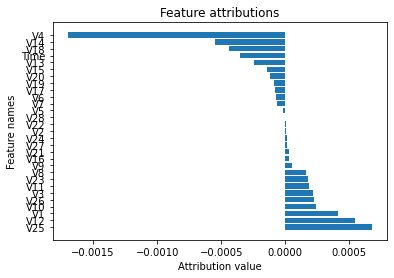

In [65]:
explanation[0].visualize_top_k_features(k=len(newobs[0]))

---
## Example-Based Explanations